1. Carga de datos
Se leen los archivos train.csv y test.csv con pandas.
2. Ingeniería de características
- Se extrae el año desde PERIODO.
- Se crean nuevas variables basadas en relaciones matemáticas (COEF_RATIO, COEF_SUMA).
- Se transforma la educación de los padres en una escala numérica simplificada.

3. Preparación de datos
- X: Variables predictoras del dataset de entrenamiento (se eliminan ID y RENDIMIENTO_GLOBAL).
- y: Variable objetivo (RENDIMIENTO_GLOBAL).
- X_test: Variables predictoras del dataset de prueba.

4. Transformaciones
Se define un ColumnTransformer que:
- Imputa valores faltantes en variables categóricas y las codifica con TargetEncoder.
- Imputa valores faltantes en variables numéricas y las normaliza con StandardScaler.

5. Pipeline de Machine Learning
Se construye un Pipeline con:
- Preprocesamiento
- Selección de características con SelectFromModel usando LightGBM.
- Clasificador final con LGBMClassifier.

6. Validación cruzada
- Se utiliza StratifiedKFold con 5 divisiones para evaluar el modelo.
- Se genera la matriz de confusión y el reporte de clasificación.
- Se calcula el accuracy promedio de la validación cruzada.

7. Optimización de hiperparámetros
- Se realiza búsqueda aleatoria de hiperparámetros (RandomizedSearchCV) sobre el pipeline.
- Se exploran parámetros clave de LightGBM y el TargetEncoder.

8. Evaluación final
- Se obtiene el mejor modelo (search.best_estimator_).
- Se imprimen los mejores parámetros y el mejor accuracy encontrado.

9. Generación de predicciones
- Se usa el modelo optimizado para predecir RENDIMIENTO_GLOBAL en el conjunto de prueba.
- Se genera un archivo CSV submission_mejorado.csv con los resultados.

Este código es un enfoque estructurado y eficiente para clasificación con LightGBM, asegurando buena preparación de datos y ajuste de parámetros. Si quieres profundizar en alguna sección o mejorar el flujo, dime qué parte te interesa explorar más. 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import lightgbm as lgb
from category_encoders import TargetEncoder
# 1. Cargar datos
data_train = pd.read_csv('train.csv')
data_test  = pd.read_csv('test.csv')

def feature_engineering(df):
    df = df.copy()
    def eliminar_columnas_duplicadas_por_contenido(df):
        columnas_a_eliminar = []
        columnas = df.columns
        for i in range(len(columnas)):
            for j in range(i + 1, len(columnas)):
                col1 = columnas[i]
                col2 = columnas[j]
                # Verificar si tienen los mismos valores (ignorando NaNs)
                if df[col1].equals(df[col2]):
                    columnas_a_eliminar.append(col2)
        return df.drop(columns=columnas_a_eliminar)
    # Eliminar columnas duplicadas
    df = eliminar_columnas_duplicadas_por_contenido(df)
    df = df.loc[:, ~df.columns.duplicated()]
    # Conversión de PERIODO a año
    df['ANIO'] = (df['PERIODO'] - 20183) // 100 + 2018
    # Interacciones entre coeficientes
    df['COEF_RATIO'] = df['coef_1'] / (df['coef_2'] + 1e-6)
    df['COEF_SUMA'] = df[['coef_1', 'coef_2', 'coef_3', 'coef_4']].sum(axis=1)
    # Simplificación educación padres
    educ_map = {'completa': 2, 'incompleta': 1, 'otros': 0}
    for col in ['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']:
        df[col + '_SIMPL'] = (
            df[col]
            .str.extract('(completa|incompleta)')[0]
            .fillna('otros')
            .map(educ_map))
    # basadas en coeficientes
    df['COEF_PROMEDIO'] = df[['coef_1', 'coef_2', 'coef_3', 'coef_4']].mean(axis=1)
    df['COEF_MAX'] = df[['coef_1', 'coef_2', 'coef_3', 'coef_4']].max(axis=1)
    df['COEF_MIN'] = df[['coef_1', 'coef_2', 'coef_3', 'coef_4']].min(axis=1)
    df['COEF_RANGO'] = df['COEF_MAX'] - df['COEF_MIN']
    df['COEF_MEJORA'] = df['coef_4'] - df['coef_1']
    # Horas de trabajo en formato numérico
    trabajo_map = {
        '0': 0,
        'Menos de 10 horas': 1,
        'Entre 11 y 20 horas': 2,
        'Entre 21 y 30 horas': 3,
        'Más de 30 horas': 4}
    df['ESTU_HORAS_TRABAJO_NUM'] = df['ESTU_HORASSEMANATRABAJA'].map(trabajo_map)
    df['COEF_X_TRABAJO'] = df['COEF_PROMEDIO'] * df['ESTU_HORAS_TRABAJO_NUM']
    # Estrato en formato numérico y vulnerabilidad
    estrato_map = {
        'Estrato 1': 1,
        'Estrato 2': 2,
        'Estrato 3': 3,
        'Estrato 4': 4,
        'Estrato 5': 5,
        'Estrato 6': 6,}
    df['ESTRATO_NUM'] = df['FAMI_ESTRATOVIVIENDA'].map(estrato_map)
    df['VULNERABLE'] = ((df['ESTRATO_NUM'] <= 2) & (df['FAMI_TIENELAVADORA'] == 'No')).astype(int)
    # Clasificación por programa académico
    df['ES_INGENIERIA'] = df['ESTU_PRGM_ACADEMICO'].str.contains('INGENIERIA', case=False, na=False).astype(int)
    df['ES_LICENCIATURA'] = df['ESTU_PRGM_ACADEMICO'].str.contains('LICENCIATURA', case=False, na=False).astype(int)
    # Tratamiento de valores faltantes
    # Categóricas: imputación con moda
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        mode = df[col].mode()
        if not mode.empty:
            df[col] = df[col].fillna(mode[0])
    # Numéricas: imputación con mediana
    numerical_cols = df.select_dtypes(include=['number']).columns
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].median())
    return df.drop(columns=['PERIODO'], axis=1)

# 3. Preparar datos
X       = train_data.drop(['ID', 'RENDIMIENTO_GLOBAL'], axis=1)
y       = train_data['RENDIMIENTO_GLOBAL']
X_test  = test_data.drop('ID', axis=1)

# 4. Definir transformaciones
numeric_features     = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', TargetEncoder())
    ]), categorical_features),
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features)
])

# 5. Pipeline completo con selección de características y clasificador
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(lgb.LGBMClassifier())),
    ('classifier', lgb.LGBMClassifier(
        objective='multiclass',
        n_jobs=-1,
        random_state=42
    ))
])

# 6. Validación cruzada y visualización
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predicciones con CV
y_pred_cv = cross_val_predict(full_pipeline, X, y, cv=cv, n_jobs=-1)

# Matriz de confusión
tm = confusion_matrix(y, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=tm)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión (CV)')
plt.show()

# Reporte de clasificación
print("Reporte de clasificación (CV):")
print(classification_report(y, y_pred_cv))

# Score promedio de accuracy
cv_scores = cross_val_score(full_pipeline, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"Accuracy promedio (CV): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 7. Optimización de hiperparámetros
param_dist = {
    'classifier__num_leaves': [31, 63, 127],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [300, 500],
    'classifier__colsample_bytree': [0.6, 0.8],
    'preprocessor__cat__encoder__smoothing': [20, 50]
}

search = RandomizedSearchCV(
    full_pipeline,
    param_dist,
    n_iter=30,
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)

# 8. Evaluación final
best_model = search.best_estimator_
print(f"Mejor accuracy: {search.best_score_:.4f}")
print("Mejores parámetros:", search.best_params_)

# 9. Generar predicciones
test_preds = best_model.predict(X_test)
submission = pd.DataFrame({'ID': test_data['ID'], 'RENDIMIENTO_GLOBAL': test_preds})
submission.to_csv('submission_mejorado.csv', index=False)


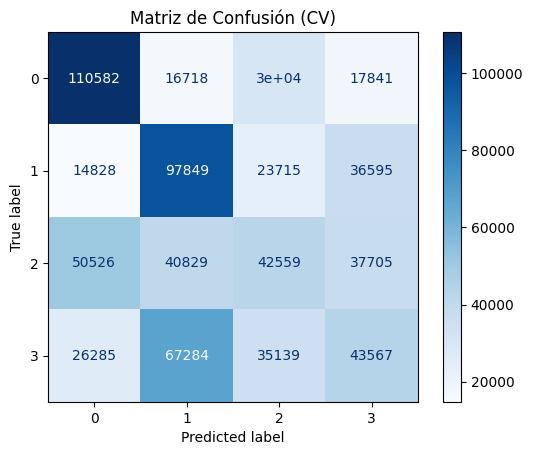

Reporte de clasificación (CV):
              precision    recall  f1-score   support

        alto       0.55      0.63      0.59    175619
        bajo       0.44      0.57      0.49    172987
  medio-alto       0.32      0.25      0.28    171619
  medio-bajo       0.32      0.25      0.28    172275

    accuracy                           0.43    692500
   macro avg       0.41      0.42      0.41    692500
weighted avg       0.41      0.43      0.41    692500

Accuracy promedio (CV): 0.4254 ± 0.0012


c:\Users\danie\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\danie\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\danie\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\danie\AppData\Local\Programs\Python\Python313\Lib\subprocess.py

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3083
[LightGBM] [Info] Number of data points in the train set: 692500, number of used features: 32
[LightGBM] [Info] Start training from score -1.371991
[LightGBM] [Info] Start training from score -1.387092
[LightGBM] [Info] Start training from score -1.395031
[LightGBM] [Info] Start training from score -1.391216


c:\Users\danie\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 692500, number of used features: 6
[LightGBM] [Info] Start training from score -1.371991
[LightGBM] [Info] Start training from score -1.387092
[LightGBM] [Info] Start training from score -1.395031
[LightGBM] [Info] Start training from score -1.391216
Mejor accuracy: 0.4305
Mejores parámetros: {'preprocessor__cat__encoder__smoothing': 50, 'classifier__num_leaves': 127, 'classifier__n_estimators': 300, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.6}


c:\Users\danie\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(
c:\Users\danie\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import lightgbm as lgb
from category_encoders import TargetEncoder
# 1. Cargar datos
data_train = pd.read_csv('train.csv')
data_test  = pd.read_csv('test.csv')

# 2. Ingeniería de características
def feature_engineering(df):
    df = df.copy()
    def eliminar_columnas_duplicadas_por_contenido(df):
        columnas_a_eliminar = []
        columnas = df.columns
        for i in range(len(columnas)):
            for j in range(i + 1, len(columnas)):
                col1 = columnas[i]
                col2 = columnas[j]
                # Verificar si tienen los mismos valores (ignorando NaNs)
                if df[col1].equals(df[col2]):
                    columnas_a_eliminar.append(col2)
        return df.drop(columns=columnas_a_eliminar)
    # Eliminar columnas duplicadas
    df = eliminar_columnas_duplicadas_por_contenido(df)
    df = df.loc[:, ~df.columns.duplicated()]
    # Conversión de PERIODO a año
    df['ANIO'] = (df['PERIODO'] - 20183) // 100 + 2018
    # Interacciones entre coeficientes
    df['COEF_RATIO'] = df['coef_1'] / (df['coef_2'] + 1e-6)
    df['COEF_SUMA'] = df[['coef_1', 'coef_2', 'coef_3', 'coef_4']].sum(axis=1)
    # Simplificación educación padres
    educ_map = {'completa': 2, 'incompleta': 1, 'otros': 0}
    for col in ['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']:
        df[col + '_SIMPL'] = (
            df[col]
            .str.extract('(completa|incompleta)')[0]
            .fillna('otros')
            .map(educ_map))
    # basadas en coeficientes
    df['COEF_PROMEDIO'] = df[['coef_1', 'coef_2', 'coef_3', 'coef_4']].mean(axis=1)
    df['COEF_MAX'] = df[['coef_1', 'coef_2', 'coef_3', 'coef_4']].max(axis=1)
    df['COEF_MIN'] = df[['coef_1', 'coef_2', 'coef_3', 'coef_4']].min(axis=1)
    df['COEF_RANGO'] = df['COEF_MAX'] - df['COEF_MIN']
    df['COEF_MEJORA'] = df['coef_4'] - df['coef_1']
    # Horas de trabajo en formato numérico
    trabajo_map = {
        '0': 0,
        'Menos de 10 horas': 1,
        'Entre 11 y 20 horas': 2,
        'Entre 21 y 30 horas': 3,
        'Más de 30 horas': 4}
    df['ESTU_HORAS_TRABAJO_NUM'] = df['ESTU_HORASSEMANATRABAJA'].map(trabajo_map)
    df['COEF_X_TRABAJO'] = df['COEF_PROMEDIO'] * df['ESTU_HORAS_TRABAJO_NUM']
    # Estrato en formato numérico y vulnerabilidad
    estrato_map = {
        'Estrato 1': 1,
        'Estrato 2': 2,
        'Estrato 3': 3,
        'Estrato 4': 4,
        'Estrato 5': 5,
        'Estrato 6': 6,}
    df['ESTRATO_NUM'] = df['FAMI_ESTRATOVIVIENDA'].map(estrato_map)
    df['VULNERABLE'] = ((df['ESTRATO_NUM'] <= 2) & (df['FAMI_TIENELAVADORA'] == 'No')).astype(int)
    # Clasificación por programa académico
    df['ES_INGENIERIA'] = df['ESTU_PRGM_ACADEMICO'].str.contains('INGENIERIA', case=False, na=False).astype(int)
    df['ES_LICENCIATURA'] = df['ESTU_PRGM_ACADEMICO'].str.contains('LICENCIATURA', case=False, na=False).astype(int)
    # Tratamiento de valores faltantes
    # Categóricas: imputación con moda
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        mode = df[col].mode()
        if not mode.empty:
            df[col] = df[col].fillna(mode[0])
    # Numéricas: imputación con mediana
    numerical_cols = df.select_dtypes(include=['number']).columns
    for col in numerical_cols:
        df[col] = df[col].fillna(df[col].median())
    return df.drop(columns=['PERIODO'], axis=1)


train_data = feature_engineering(data_train)
test_data  = feature_engineering(data_test)

# 3. Preparar datos
X       = train_data.drop(['ID', 'RENDIMIENTO_GLOBAL'], axis=1)
y       = train_data['RENDIMIENTO_GLOBAL']
X_test  = test_data.drop('ID', axis=1)

# 4. Definir transformaciones
numeric_features     = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', TargetEncoder())
    ]), categorical_features),
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features)
])

# 5. Pipeline completo con selección de características y clasificador
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(lgb.LGBMClassifier())),
    ('classifier', lgb.LGBMClassifier(
        objective='multiclass',
        n_jobs=-1,
        random_state=42
    ))
])

# 6. Validación cruzada y visualización
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Predicciones con CV
y_pred_cv = cross_val_predict(full_pipeline, X, y, cv=cv, n_jobs=-1)

# Matriz de confusión
tm = confusion_matrix(y, y_pred_cv)
disp = ConfusionMatrixDisplay(confusion_matrix=tm)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión (CV)')
plt.show()

# Reporte de clasificación
print("Reporte de clasificación (CV):")
print(classification_report(y, y_pred_cv))

# Score promedio de accuracy
cv_scores = cross_val_score(full_pipeline, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"Accuracy promedio (CV): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# 7. Optimización de hiperparámetros
param_dist = {
    'classifier__num_leaves': [31, 63, 127],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__n_estimators': [300, 500],
    'classifier__colsample_bytree': [0.6, 0.8],
    'preprocessor__cat__encoder__smoothing': [20, 50]
}

search = RandomizedSearchCV(
    full_pipeline,
    param_dist,
    n_iter=30,
    cv=StratifiedKFold(3, shuffle=True, random_state=42),
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

search.fit(X, y)

# 8. Evaluación final
best_model = search.best_estimator_
print(f"Mejor accuracy: {search.best_score_:.4f}")
print("Mejores parámetros:", search.best_params_)

# 9. Generar predicciones
test_preds = best_model.predict(X_test)
submission = pd.DataFrame({'ID': test_data['ID'], 'RENDIMIENTO_GLOBAL': test_preds})
submission.to_csv('submission.csv', index=False)
